## Initial EDA and Imports

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import spacy
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support 
import matplotlib.pyplot as plt
from scipy.sparse import identity
import seaborn as sns
import statistics

Import in the goodread 10k datasets

In [2]:
ratings = pd.read_csv('ratings.csv')
to_read = pd.read_csv('to_read.csv')
books = pd.read_csv('books.csv')
tags = pd.read_csv('tags.csv')
book_tags = pd.read_csv('book_tags.csv')

Import the CMU Wikipedia Summaries Dataset

In [3]:
cmu_summaries = pd.read_csv('booksummaries.txt', delimiter='\t', names=['Wiki ID','Freebase ID','Title','Author','Pub Date','Genres','Plot Summary'])

Look at descriptions and heads to get an idea of the form of each of the datasets

In [4]:
ratings.describe(), ratings.head()

(            user_id       book_id        rating
 count  5.976479e+06  5.976479e+06  5.976479e+06
 mean   2.622446e+04  2.006477e+03  3.919866e+00
 std    1.541323e+04  2.468499e+03  9.910868e-01
 min    1.000000e+00  1.000000e+00  1.000000e+00
 25%    1.281300e+04  1.980000e+02  3.000000e+00
 50%    2.593800e+04  8.850000e+02  4.000000e+00
 75%    3.950900e+04  2.973000e+03  5.000000e+00
 max    5.342400e+04  1.000000e+04  5.000000e+00,    user_id  book_id  rating
 0        1      258       5
 1        2     4081       4
 2        2      260       5
 3        2     9296       5
 4        2     2318       3)

In [5]:
to_read.describe()

,user_id,book_id
count,912705.000000,912705.000000
mean,27668.980115,2454.739538
std,14775.096388,2626.359921
min,1.000000,1.000000
25%,15507.000000,360.000000
50%,27799.000000,1381.000000
75%,40220.000000,3843.000000
max,53424.000000,10000.000000


In [6]:
books.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')

In [7]:
tags.describe(), tags.head(5)

(             tag_id
 count  34252.000000
 mean   17125.500000
 std     9887.845047
 min        0.000000
 25%     8562.750000
 50%    17125.500000
 75%    25688.250000
 max    34251.000000,    tag_id tag_name
 0       0        -
 1       1     --1-
 2       2    --10-
 3       3    --12-
 4       4   --122-)

In [8]:
book_tags.describe(), book_tags.head(5)

(       goodreads_book_id         tag_id          count
 count       9.999120e+05  999912.000000  999912.000000
 mean        5.263442e+06   16324.527073     208.869633
 std         7.574057e+06    9647.846196    3501.265173
 min         1.000000e+00       0.000000      -1.000000
 25%         4.622700e+04    8067.000000       7.000000
 50%         3.948410e+05   15808.000000      15.000000
 75%         9.378297e+06   24997.000000      40.000000
 max         3.328864e+07   34251.000000  596234.000000,
    goodreads_book_id  tag_id   count
 0                  1   30574  167697
 1                  1   11305   37174
 2                  1   11557   34173
 3                  1    8717   12986
 4                  1   33114   12716)

In [9]:
cmu_summaries.describe(), cmu_summaries.head(5)

(            Wiki ID
 count  1.655900e+04
 mean   1.101506e+07
 std    9.537337e+06
 min    6.200000e+02
 25%    2.913627e+06
 50%    7.948709e+06
 75%    1.789919e+07
 max    3.715950e+07,
    Wiki ID Freebase ID                                      Title  \
 0      620     /m/0hhy                                Animal Farm   
 1      843     /m/0k36                         A Clockwork Orange   
 2      986     /m/0ldx                                 The Plague   
 3     1756     /m/0sww  An Enquiry Concerning Human Understanding   
 4     2080     /m/0wkt                       A Fire Upon the Deep   
 
             Author    Pub Date  \
 0    George Orwell  1945-08-17   
 1  Anthony Burgess        1962   
 2     Albert Camus        1947   
 3       David Hume         NaN   
 4     Vernor Vinge         NaN   
 
                                               Genres  \
 0  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   
 1  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   
 2  {

### Build and Merge as is appropriate
Figure out how to appropriately merge the books and cmu_summareis datasets

In [10]:
fullish = books.merge(cmu_summaries, left_on=['title'], right_on=['Title']).drop('title',axis=1)

In [11]:
fullish2 = books.merge(cmu_summaries, left_on=['original_title'], right_on=['Title']).drop('original_title',axis=1)

In [12]:
full = fullish2.append(fullish, sort=True)
full = full.drop_duplicates(subset=['goodreads_book_id'])

In [13]:
X = full['Plot Summary']
y = np.rint(full['average_rating'])
y = np.asarray(y, dtype = "|S6")
train_X, test_X, train_y, test_y = train_test_split(X,y, random_state=42)

In [14]:
vectorizer = CountVectorizer(stop_words = 'english', ngram_range=(1,2))
train_X1 = vectorizer.fit_transform(train_X)
test_X1 = vectorizer.transform(test_X)

In [15]:
vectorizer2 = TfidfVectorizer(stop_words='english')
train_X2 = vectorizer2.fit_transform(train_X)
test_X2 = vectorizer2.transform(test_X)

In [16]:
NB = MultinomialNB()
NB.fit(train_X1,train_y)

NB2 = MultinomialNB()
NB2.fit(train_X2, train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [17]:
accuracy_train1 = NB.score(train_X1,train_y)
accuracy_train2 = NB2.score(train_X2,train_y)

accuracy1 = NB.score(test_X1,test_y)
accuracy2 = NB2.score(test_X2,test_y)

accuracy_train1, accuracy_train2, accuracy1, accuracy2

(0.9904222899434044,
 0.9586417065737919,
 0.9608355091383812,
 0.9608355091383812)

In [18]:
words = np.array(vectorizer.get_feature_names())

x = identity(test_X1.shape[1])
probs = NB.predict_log_proba(x)[:,0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	
               using 1.00
             dresden 1.00
                alex 1.00
              planet 1.00
              imriel 1.00
                  34 1.00
               anita 1.00
           christian 1.00
             vampire 1.00
              heaven 1.00
Bad words	
          dimmesdale 0.35
                kino 0.35
         ravenstreet 0.33
            mr kurtz 0.32
               kurtz 0.29
            wideacre 0.29
              marlow 0.26
                brrr 0.22
           valentina 0.19
              nevare 0.16


In [19]:
words2 = np.array(vectorizer2.get_feature_names())

x2 = identity(test_X2.shape[1])
probs2 = NB2.predict_log_proba(x2)[:,0]
ind2 = np.argsort(probs2)

good_words2 = words2[ind2[:10]]
bad_words2 = words2[ind2[-10:]]

good_prob2 = probs2[ind2[:10]]
bad_prob2 = probs2[ind2[-10:]]

print("Good words\t")
for w, p in zip(good_words2, good_prob2):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t")
for w, p in zip(bad_words2, bad_prob2):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	
                time 1.00
              mother 1.00
                king 1.00
                home 1.00
              family 1.00
                life 1.00
                 new 1.00
              school 1.00
                help 1.00
                ship 1.00
Bad words	
               archy 0.92
               buick 0.92
                kino 0.92
              tassie 0.92
              nickie 0.92
                brrr 0.91
              marlow 0.91
           valentina 0.91
               kurtz 0.91
              nevare 0.89


### Genre List
Create Genre list from the CMU dataset

In [20]:
cmu_summ_final = cmu_summaries
cmu_summ_final['Sep Genres'] = cmu_summ_final['Genres'].str.findall('[A-Z]\w.+?(?="|\\\\)')

In [21]:
cmu_summ_final = cmu_summ_final.dropna(axis=0)
cmu_summ_final = cmu_summ_final.reset_index()
cmu_summ_final = cmu_summ_final.drop('index',axis=1)
cmu_summ_final.head()

,Wiki ID,Freebase ID,Title,Author,Pub Date,Genres,Plot Summary,Sep Genres
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...","[Roman , Satire, Children's literature, Specul..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...","[Science Fiction, Novella, Speculative fiction..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,"[Existentialism, Fiction, Absurdist fiction, N..."
3,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...","[War novel, Roman ]"
4,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger...","[Children's literature, Fantasy, Speculative f..."


In [23]:
cmu_summ_final[cmu_summ_final['Sep Genres']=='Computer Science']

,Wiki ID,Freebase ID,Title,Author,Pub Date,Genres,Plot Summary,Sep Genres


In [83]:
genre_list = []
for i in np.arange(0,len(cmu_summ_final['Sep Genres'])):
    genre_list = genre_list + cmu_summ_final['Sep Genres'][i]
genre_list = set(genre_list)
genre_list = list(genre_list)

In [23]:
genre_list = [sub.replace(" ","") for sub in genre_list]
len(genre_list)

214

In [84]:
genre_list

['Social science fiction',
 'Epic Science Fiction and Fantasy',
 'Serial',
 'Comic science fiction',
 'Locked room mystery',
 'Paranormal romance',
 'Indian chick lit',
 'Historical novel',
 'Comic novel',
 'Autobiography',
 'Catastrophic literature',
 'Play',
 'Zombie',
 'Lost World',
 'Popular culture',
 'Cozy',
 'Ergodic literature',
 'Soft science fiction',
 'Speculative fiction',
 'Alternate history',
 'Biography',
 'Dying Earth subgenre',
 'Subterranean fiction',
 'Science',
 'Social sciences',
 'Campus novel',
 'Religion',
 'Non-fiction novel',
 'Fairy tale',
 'Experimental literature',
 'Gay Themed',
 'Historical fiction',
 'Mathematics',
 'Dark fantasy',
 'Existentialism',
 'Picaresque novel',
 'Contemporary fantasy',
 'Supernatural',
 'Biographical novel',
 'Treatise',
 'Polemic',
 'Thriller',
 'Zombies in popular culture',
 'School story',
 'Apocalyptic and post-apocalyptic fiction',
 'Urban fantasy',
 'Conspiracy',
 'Popular science',
 'Western',
 'Graphic novel',
 'Spy fic

In [32]:
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.tokens import Doc
nlp = spacy.load('en_core_web_sm')

In [33]:
def token_match_drop(doc):
    indexes = []
    for index, token in enumerate(doc):
        if (token.pos_ in ('PUNCT','SPACE','PROPN')):
            indexes.append(index)
    np_array = doc.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA])
    np_array = np.delete(np_array, indexes, axis=0)
    doc2 = Doc(doc.vocab, words=[t.text for i, t in enumerate(doc) if i not in indexes])
    doc2.from_array([LOWER, POS, ENT_TYPE, IS_ALPHA], np_array)
    return doc2

In [34]:
#do not run unless completely necessary
#summ = cmu_summ_final['Plot Summary']
#summ_nlp = [nlp(i) for i in summ]
#cmu_summ_final['nlpSumm'] = [token_match_drop(i) for i in summ_nlp]
#cmu_summ_final.to_csv('summ_final.csv')

#Read from the above file once done!

In [46]:
cmu_summ_final.to_csv('summ_final.csv', index=None)
cmu_summ_final['Sep Genres'][0]


['Roman ', 'Satire', "Children's literature", 'Speculative fiction', 'Fiction']

EDA for presentation

In [85]:
genre_dict = dict.fromkeys(genre_list,0)

In [86]:
for i in cmu_summ_final['Sep Genres'][1:]:
    for j in i:
        genre_dict[j] = genre_dict[j] + 1

In [97]:
genres_df = pd.DataFrame.from_dict(genre_dict, orient='index')
genres_df = genres_df.reset_index()
genres_df.columns = ['Genre', 'Count']
genres_df.sort_values('Count', ascending=False).head()['Genre']

134                Fiction
18     Speculative fiction
108                  Novel
117        Science Fiction
156                Fantasy
Name: Genre, dtype: object

In [159]:
genres_df.sort_values('Count', ascending=False).head(10)

,Genre,Count
134,Fiction,3674
18,Speculative fiction,3270
108,Novel,2088
117,Science Fiction,2001
156,Fantasy,1863
68,Children's literature,1627
107,Mystery,973
154,Young adult literature,625
61,Crime Fiction,557
7,Historical novel,551


Text(0, 0.5, 'Count')

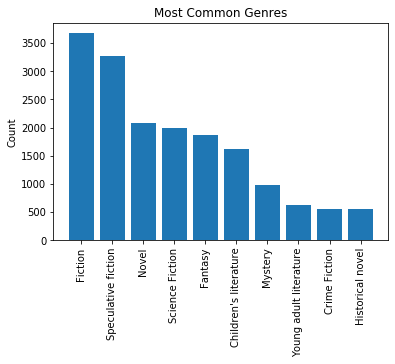

In [103]:
plt.bar(genres_df.sort_values('Count', ascending=False).head(10)['Genre'],genres_df.sort_values('Count', ascending=False).head(10)['Count'])
plt.xticks(rotation=90)
plt.title('Most Common Genres')
plt.ylabel('Count')

In [155]:
genre_den = genres_df.merge(com_genre_df, left_on='Genre', right_on='Subgenres', how='inner').drop(['Subgenres','Genre_x'],axis=1)
genre_den['Total'] = genre_den.groupby('Genre_y')['Count'].transform('sum')
genre_den = genre_den.drop('Count',axis=1).drop_duplicates('Genre_y')
genre_den

,Genre_y,Total
0,Science fiction,2223
2,Mystery,981
3,Romance,377
4,Historical fiction,885
5,Comedy,318
6,Horror,495
7,Crime fiction,2
9,Speculative fiction,3419
10,Alternate history,153
14,Fantasy,2030


Text(0.5, 1.0, 'Most Common by Genre')

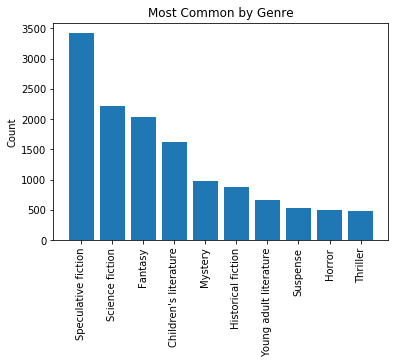

In [157]:
plt.bar(genre_den.sort_values('Total', ascending=False).head(10)['Genre_y'],genre_den.sort_values('Total', ascending=False).head(10)['Total'])
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Most Common by Genre')

In [171]:
cmu_summ_final['nlpSumm']
summ_len_dict = {}
for i in np.arange(0,len(cmu_summ_final['nlpSumm'])):
    summ_len_dict[i] = len(cmu_summ_final['nlpSumm'][i])
summ_len_dict

{0: 889,
 1: 955,
 2: 1058,
 3: 739,
 4: 1021,
 5: 51,
 6: 243,
 7: 98,
 8: 543,
 9: 1537,
 10: 851,
 11: 858,
 12: 493,
 13: 877,
 14: 1440,
 15: 825,
 16: 707,
 17: 1325,
 18: 1951,
 19: 362,
 20: 1263,
 21: 2431,
 22: 2972,
 23: 752,
 24: 1753,
 25: 1341,
 26: 191,
 27: 66,
 28: 242,
 29: 940,
 30: 936,
 31: 1252,
 32: 198,
 33: 851,
 34: 1056,
 35: 551,
 36: 323,
 37: 349,
 38: 658,
 39: 992,
 40: 855,
 41: 1054,
 42: 769,
 43: 1003,
 44: 897,
 45: 770,
 46: 221,
 47: 749,
 48: 700,
 49: 1160,
 50: 728,
 51: 2083,
 52: 442,
 53: 681,
 54: 249,
 55: 455,
 56: 632,
 57: 547,
 58: 611,
 59: 903,
 60: 648,
 61: 184,
 62: 422,
 63: 867,
 64: 947,
 65: 1618,
 66: 736,
 67: 973,
 68: 1703,
 69: 601,
 70: 673,
 71: 579,
 72: 1104,
 73: 179,
 74: 1050,
 75: 932,
 76: 481,
 77: 775,
 78: 165,
 79: 561,
 80: 550,
 81: 154,
 82: 931,
 83: 1113,
 84: 928,
 85: 900,
 86: 744,
 87: 265,
 88: 235,
 89: 462,
 90: 60,
 91: 231,
 92: 1205,
 93: 139,
 94: 689,
 95: 792,
 96: 1028,
 97: 298,
 98: 452,


In [175]:
summ_len_df = pd.DataFrame.from_dict(summ_len_dict,orient='index')
summ_len_df

,0
0,889
1,955
2,1058
3,739
4,1021
5,51
6,243
7,98
8,543
9,1537


Text(0.5, 0, 'Word Count')

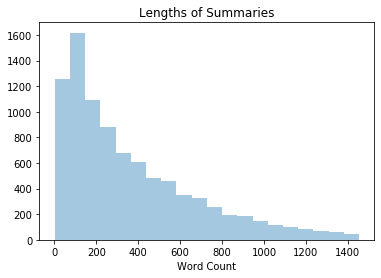

In [191]:
sns.distplot(summ_len_df.sort_values(by=0).head(9000), kde=False, bins=20)
plt.title('Lengths of Summaries')
plt.xlabel('Word Count')

In [201]:
summ_len_df.describe()

,0
count,9293.000000
mean,419.329926
std,472.836608
min,2.000000
25%,121.000000
50%,273.000000
75%,561.000000
max,9359.000000


apply sep genres to full set

In [25]:
full['Sep Genres'] = full['Genres'].str.findall('[A-Z]\w.+?(?="|\\\\)')

In [26]:
full = full.reset_index()
full = full.drop('index',axis=1)
full.head()

,Author,Freebase ID,Genres,Plot Summary,Pub Date,Title,Wiki ID,authors,average_rating,best_book_id,...,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,Sep Genres
0,Suzanne Collins,/m/04ydtzf,"{""/m/06n90"": ""Science Fiction"", ""/m/08sdrw"": ""...",The Hunger Games takes place in a nation know...,2008-09-14,The Hunger Games,20128213,Suzanne Collins,4.34,2767052,...,560092,1481305,2706317,4780653,https://images.gr-assets.com/books/1447303603s...,"The Hunger Games (The Hunger Games, #1)",2792775,4942365,155254,"[Science Fiction, Adventure novel, Alternate h..."
1,J. K. Rowling,/m/0c_vk,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Before the start of the novel, Voldemort, con...",1997-06-30,Harry Potter and the Philosopher's Stone,48648,"J.K. Rowling, Mary GrandPré",4.44,3,...,455024,1156318,3011543,4602479,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,4800065,75867,"[Children's literature, Fantasy, Speculative f..."
2,Stephenie Meyer,/m/0c34ct,"{""/m/0kflf"": ""Vampire fiction"", ""/m/03npn"": ""H...","Isabella ""Bella"" Swan moves from sunny Phoeni...",2005-10-05,Twilight,4451267,Stephenie Meyer,3.57,41865,...,793319,875073,1355439,3866839,https://images.gr-assets.com/books/1361039443s...,"Twilight (Twilight, #1)",3212258,3916824,95009,"[Vampire fiction, Horror, Speculative fiction,..."
3,Stephenie Meyer,/m/0c34ct,"{""/m/0kflf"": ""Vampire fiction"", ""/m/03npn"": ""H...","Isabella ""Bella"" Swan moves from sunny Phoeni...",2005-10-05,Twilight,4451267,Meg Cabot,4.26,93724,...,5446,10693,16920,32489,https://images.gr-assets.com/books/1327959055s...,"Twilight (The Mediator, #6)",2349900,34286,979,"[Vampire fiction, Horror, Speculative fiction,..."
4,Stephenie Meyer,/m/0c34ct,"{""/m/0kflf"": ""Vampire fiction"", ""/m/03npn"": ""H...","Isabella ""Bella"" Swan moves from sunny Phoeni...",2005-10-05,Twilight,4451267,"Leigh Nichols, Dean Koontz",3.81,32453,...,4824,5482,4364,14476,https://images.gr-assets.com/books/1327999566s...,The Servants of Twilight,1049922,15878,274,"[Vampire fiction, Horror, Speculative fiction,..."


In [27]:
full.dropna(axis=1)

,Freebase ID,Plot Summary,Title,Wiki ID,authors,average_rating,best_book_id,book_id,books_count,goodreads_book_id,...,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,work_id,work_ratings_count,work_text_reviews_count
0,/m/04ydtzf,The Hunger Games takes place in a nation know...,The Hunger Games,20128213,Suzanne Collins,4.34,2767052,1,272,2767052,...,66715,127936,560092,1481305,2706317,4780653,https://images.gr-assets.com/books/1447303603s...,2792775,4942365,155254
1,/m/0c_vk,"Before the start of the novel, Voldemort, con...",Harry Potter and the Philosopher's Stone,48648,"J.K. Rowling, Mary GrandPré",4.44,3,2,491,3,...,75504,101676,455024,1156318,3011543,4602479,https://images.gr-assets.com/books/1474154022s...,4640799,4800065,75867
2,/m/0c34ct,"Isabella ""Bella"" Swan moves from sunny Phoeni...",Twilight,4451267,Stephenie Meyer,3.57,41865,3,226,41865,...,456191,436802,793319,875073,1355439,3866839,https://images.gr-assets.com/books/1361039443s...,3212258,3916824,95009
3,/m/0c34ct,"Isabella ""Bella"" Swan moves from sunny Phoeni...",Twilight,4451267,Meg Cabot,4.26,93724,4234,38,93724,...,245,982,5446,10693,16920,32489,https://images.gr-assets.com/books/1327959055s...,2349900,34286,979
4,/m/0c34ct,"Isabella ""Bella"" Swan moves from sunny Phoeni...",Twilight,4451267,"Leigh Nichols, Dean Koontz",3.81,32453,7047,62,32453,...,191,1017,4824,5482,4364,14476,https://images.gr-assets.com/books/1327999566s...,1049922,15878,274
5,/m/0c34ct,"Isabella ""Bella"" Swan moves from sunny Phoeni...",Twilight,4451267,Erin Hunter,4.30,252938,8354,41,252938,...,138,473,2514,4665,8914,15604,https://images.gr-assets.com/books/1363786463s...,245106,16704,361
6,/m/0jqbz,The book opens with the Finch family's ancest...,To Kill a Mockingbird,73408,Harper Lee,4.25,2657,4,487,2657,...,60427,117415,446835,1001952,1714267,3198671,https://images.gr-assets.com/books/1361975680s...,3275794,3340896,72586
7,/m/0k2y7,"The story begins with the narrator, Nick Carr...",The Great Gatsby,76033,F. Scott Fitzgerald,3.89,4671,5,1356,4671,...,86236,197621,606158,936012,947718,2683664,https://images.gr-assets.com/books/1490528560s...,245494,2773745,51992
8,/m/0gy1w6j,"Narrator Hazel Grace Lancaster, a sixteen-yea...",The Fault in Our Stars,32262844,John Green,4.26,11870085,6,226,11870085,...,47994,92723,327550,698471,1311871,2346404,https://images.gr-assets.com/books/1360206420s...,16827462,2478609,140739
9,/m/019g32,The majority of the novel takes place over tw...,The Catcher in the Rye,186258,J.D. Salinger,3.79,5107,8,360,5107,...,109383,185520,455042,661516,709176,2044241,https://images.gr-assets.com/books/1398034300s...,3036731,2120637,44920


In [104]:
form_dict = {'Anthology':'Fiction',
             'Comic book':'Fiction',
             'Comics':'Fiction',
             'Epistolary novel':'Fiction',
             'Ergodic literature':'Fiction',
             'Experimental literature':'Fiction',
             'Fiction':'Fiction',
             'First-person narrative':'Fiction',
             'Gamebook':'Fiction',
             'Graphic novel':'Fiction',
             'Non-fiction novel':'Fiction',
             'Novel':'Fiction',
             'Novella':'Fiction',
             'Parallel novel':'Fiction',
             'Picture book':'Fiction',
             'Play':'Fiction',
             'Poetry':'Fiction',
             'Prose':'Fiction',
             'Prose poetry':'Fiction',
             'Religious text':'Fiction',
             'Role-playing game':'Fiction',
             'Serial':'Fiction',
             'Short story':'Fiction',
             'Autobiographical novel':'Non-fiction',
             'Autobiography':'Non-fiction',
             'Biographical novel':'Non-fiction',
             'Biography':'Non-fiction',
             'Creative nonfiction':'Non-fiction',
             'Essay':'Non-fiction',
             'Memoir':'Non-fiction',
             'Non-fiction':'Non-fiction',
             'Personal journal':'Non-fiction',
             'Travel literature':'Non-fiction',
             'Treatise':'Non-fiction'}

In [105]:
form_df = pd.DataFrame.from_dict(form_dict, orient='index')
form_df = form_df.reset_index()
form_df.columns = ['Forms','FicNonfic']

In [106]:
cmu_summ_final.head()

,Wiki ID,Freebase ID,Title,Author,Pub Date,Genres,Plot Summary,Sep Genres,nlpSumm
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...","[Roman , Satire, Children's literature, Specul...","(the, old, boar, on, the, calls, the, animals,..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...","[Science Fiction, Novella, Speculative fiction...","(a, teenager, living, in, near, future, leads,..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,"[Existentialism, Fiction, Absurdist fiction, N...","(The, text, of, The, is, divided, into, five, ..."
3,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...","[War novel, Roman ]","(The, book, tells, the, story, of, a, German, ..."
4,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger...","[Children's literature, Fantasy, Speculative f...","(is, a, young, boy, on, one, of, the, larger, ..."


In [57]:
cmu_summ_comp = cmu_summ_final.drop(['Wiki ID','Freebase ID','Pub Date','Genres'], axis=1)
cmu_summ_comp = cmu_summ_comp['Sep Genres'].apply(pd.Series).merge(cmu_summ_comp, left_index=True, right_index=True)
cmu_summ_comp = cmu_summ_comp.drop(['Sep Genres'], axis=1)
cmu_summ_comp = cmu_summ_comp.melt(id_vars = ['Title','Author','Plot Summary'], value_name = 'genre')
cmu_summ_comp = cmu_summ_comp.drop('variable', axis=1)
cmu_summ_comp = cmu_summ_comp.dropna()
cmu_summ_comp.head()

,Title,Author,Plot Summary,genre
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",Roman
1,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",Science Fiction
2,The Plague,Albert Camus,The text of The Plague is divided into five p...,Existentialism
3,All Quiet on the Western Front,Erich Maria Remarque,"The book tells the story of Paul Bäumer, a Ge...",War novel
4,A Wizard of Earthsea,Ursula K. Le Guin,"Ged is a young boy on Gont, one of the larger...",Children's literature


In [55]:
cmu_summ_comp[cmu_summ_comp['genre']=='Sports']

,Title,Author,Plot Summary,genre
6427,Now I Can Die in Peace,Bill Simmons,Now I Can Die in Peace is a collection of Sim...,Sports
7683,"Sports, Sin and Subversion",Evan X Hyde,Hyde takes as his point of departure his chil...,Sports
8627,The Book of Basketball: The NBA According to t...,Bill Simmons,"From The Wall Street Journal: :""In what passe...",Sports
8670,The David Beckham Experiment,Grant Wahl,"In January 2007, 31-year-old Beckham, one of ...",Sports
12038,Hover Car Racer,Matthew Reilly,Jason Chaser is an independent Hover Car race...,Sports


In [108]:
cmu_summ_forms = cmu_summ_comp.merge(form_df, left_on='genre', right_on='Forms', how='outer')
cmu_summ_forms = cmu_summ_forms.dropna()

In [109]:
cmu_summ_forms['FicNonfic'].value_counts()

Fiction        6045
Non-fiction     457
Name: FicNonfic, dtype: int64

In [147]:
com_genre_dict = {'Adventure':'Adventure','Adventure novel':'Adventure', 'Naval Adventure':'Adventure',
                  'Alternate history':'Alternate history',
                  "Children's literature":"Children's literature","Boys' school stories":"Children's literature",'Juvenile fantasy':"Children's literature",
                  'Comedy':'Comedy', 'Satire':'Comedy','Farce':'Comedy','Comedy of manners':'Comedy','Parody':'Comedy','Tragic comedy':'Comedy','Black comedy':'Comedy','Comic novel':'Comedy',
                  'Crime fiction':'Crime fiction', 'Cozy':'Crime fiction',
                  'Detective fiction':'Detective fiction', 'Hardboiled':'Detective fiction','Police procedural':'Detective fiction',
                  'Spy fiction':'Spy fiction','Cabal':'Spy fiction',
                  'Fantasy':'Fantasy','Bangsian fantasy':'Fantasy','Comic fantasy':'Fantasy','Contemporary fantasy':'Fantasy','Dark fantasy':'Fantasy','Fantasy of manners':'Fantasy','Heroic fantasy':'Fantasy','High fantasy':'Fantasy','Historical fantasy':'Fantasy','Low fantasy':'Fantasy','Magic realism':'Fantasy','Sword and sorcery':'Fantasy','Urban fantasy':'Fantasy',
                  'Historical fiction':'Historical fiction','Historical novel':'Historical fiction','Historical whodunnit':'Historical fiction','Wuxia':'Historical fiction',
                  'Horror':'Horror','American Gothic Fiction':'Horror','Gothic fiction':'Horror','Vampire fiction':'Horror','Zombie':'Horror','Zombies in popular culture':'Horror',
                  'Mystery':'Mystery','Whodunit':'Mystery','Locked room mystery':'Mystery',
                  'Romance novel':'Romance','Chivalric romance':'Romance','Colonial United States romance':'Romance','Elizabthan romance':'Romance','Georgian romance':'Romance','Historical romance':'Romance','Medieval romance':'Romance','Regency romance':'Romance','Romantic comedy':'Romance','Paranormal romance':'Romance',
                  'Science Fiction':'Science fiction','Alien invasion':'Science fiction','Comic science fiction':'Science fiction','Cyberpunk':'Science fiction','Dying Earth subgenre':'Science fiction','Edisonade':'Science fiction','Feminist science ficiton':'Science fiction','Future history':'Science fiction','Hard science fiction':'Science fiction','Human extinction':'Science fiction','Invasion literature':'Science fiction','Military science fiction':'Science fiction','Planetary romance':'Science fiction','Postcyberpunk':'Science fiction','Scientific romance':'Science fiction','Social science fiction':'Science fiction','Soft science fiction':'Science fiction','Space opera':'Science fiction','Sword and planet':'Science fiction','Time travel':'Science fiction','Apocalyptic and post-apocalyptic fiction':'Science fiction','Biopunk':'Science fiction','Steampunk':'Science fiction','Subterranean fiction':'Science fiction',
                  'Speculative fiction':'Speculative fiction','Dystopia':'Speculative fiction','Superhero fiction':'Speculative fiction','Supernatural':'Speculative fiction','Ghost story':'Speculative fiction','Utopian and dystopian fiction':'Speculative fiction','Utopian fiction':'Speculative fiction',
                  'Spy fiction':'Spy fiction','Cabal':'Spy fiction',
                  'Suspense':'Suspense',
                  'Thriller':'Thriller','Techno-thriller':'Thriller','Conspiracy':'Thriller','Conspiracy fiction':'Thriller',
                  'Young adult literature':'Young adult literature', 'Bildungsroman':'Young adult literature','Coming of age':'Young adult literature','English public-school stories':'Young adult literature','School story':'Young adult literature','Light novel':'Young adult literature'}

In [150]:
com_genre_df = pd.DataFrame.from_dict(com_genre_dict, orient='index')
com_genre_df = com_genre_df.reset_index()
com_genre_df.columns = ['Subgenres','Genre']

In [149]:
cmu_summ_genre = cmu_summ_comp.merge(com_genre_df, left_on='genre', right_on='Subgenres', how='outer')
cmu_summ_genre = cmu_summ_genre.dropna()

In [113]:
cmu_summ_genre[cmu_summ_genre['Genre']=='Speculative fiction'].describe()

,Title,Author,Plot Summary,nlpSumm,genre,Subgenres,Genre
count,3271,3271,3271,3271,3271,3271,3271
unique,3252,1042,3259,3271,1,1,1
top,Haunted,K. A. Applegate,~Plot outline description~ --> <!--,"(masquerades, as, his, progenitor, and, dupes,...",Speculative fiction,Speculative fiction,Speculative fiction
freq,3,53,11,1,3271,3271,3271


In [43]:
a = cmu_summ_genre
a['id']=a['Genre'].factorize()[0]
cat_id_df = a[['Genre','id']].drop_duplicates().sort_values('id')
cat_id_df

,Genre,id
22,Science fiction,0
2105,Children's literature,1
3733,Speculative fiction,2
7004,Comedy,3
10913,Mystery,4
11886,Historical fiction,5
12227,Adventure,6
13128,Horror,7
15599,Thriller,8
16198,Fantasy,9


In [74]:
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.tokens import Doc
nlp = spacy.load('en_core_web_sm')

In [75]:
def token_match_drop(doc):
    indexes = []
    for index, token in enumerate(doc):
        if (token.pos_ in ('PUNCT','SPACE','PROPN')):
            indexes.append(index)
    np_array = doc.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA])
    np_array = np.delete(np_array, indexes, axis=0)
    doc2 = Doc(doc.vocab, words=[t.text for i, t in enumerate(doc) if i not in indexes])
    doc2.from_array([LOWER, POS, ENT_TYPE, IS_ALPHA], np_array)
    return doc2

In [83]:
text_test = cmu_summ_forms['Plot Summary'].head()
vect = CountVectorizer(stop_words = 'english')
new_text1 = vect.fit_transform(text_test)
new_text2 = nlp(text_test[7200])
new_text3 = token_match_drop(new_text2)

In [109]:
#do not run unless completely necessary
summ = cmu_summ_final['Plot Summary']
summ_nlp = [nlp(i) for i in summ]
cmu_summ_final['nlpSumm'] = [token_match_drop(i) for i in summ_nlp]

In [110]:
def good_bad_words(vectorizer, test_X1, NB):
    words = np.array(vectorizer.get_feature_names())
    x = identity(test_X1.shape[1])
    probs = NB.predict_log_proba(x)[:,0]
    ind = np.argsort(probs)
    
    good_words = words[ind[:10]]
    bad_words = words[ind[-10:]]
    good_prob = probs[ind[:10]]
    bad_prob = probs[ind[-10:]]
    
    return good_words, bad_words, good_prob, bad_prob

In [111]:
def print_good_bad_words(good_words, bad_words, good_prob, bad_prob):
    print("Good words\t")
    for w,p in zip(good_words, good_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    print("Bad words\t")
    for w, p in zip(bad_words, bad_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

In [125]:
def naive_bayes_cmufunc(full_df,column_y):
    full_df['id']=full_df[column_y].factorize()[0]
    cat_id_df = full_df[[column_y,'id']].drop_duplicates().sort_values('id')
    
    X = full_df['nlpSumm']
    y = full_df['id']
    train_X, test_X, train_y, test_y = train_test_split(X,y, random_state=42)
    
    vectorizer = CountVectorizer(stop_words = 'english')
    train_X1 = vectorizer.fit_transform(train_X)
    test_X1 = vectorizer.transform(test_X)
    vectorizer2 = TfidfVectorizer(stop_words='english')
    train_X2 = vectorizer2.fit_transform(train_X)
    test_X2 = vectorizer2.transform(test_X)

    NB = MultinomialNB()
    NB.fit(train_X1,train_y)
    NB2 = MultinomialNB()
    NB2.fit(train_X2, train_y)

    accuracy_train1 = NB.score(train_X1,train_y)
    accuracy_train2 = NB2.score(train_X2,train_y)
    accuracy1 = NB.score(test_X1,test_y)
    accuracy2 = NB2.score(test_X2,test_y)
    words_1 = good_bad_words(vectorizer, test_X1, NB)
    words_2 = good_bad_words(vectorizer2, test_X2, NB2)
    
    return accuracy_train1, accuracy_train2, accuracy1, accuracy2, words_1, words_2, cat_id_df

In [126]:
#DO NOT RUN THIS UNLESS YOU HAVE TOO!!!!!!!
[accuracy_train1, accuracy_train2, accuracy1, accuracy2, words_1, words_2, cat_id_df] = naive_bayes_cmufunc(cmu_summ_forms,'FicNonfic')
cmu_summ_ficnonfic = {'Training Accuracy':{'Count':accuracy_train1,'Tfidf':accuracy_train2},
                      'Testing Accuracy':{'Count':accuracy1,'Tfidf':accuracy2},
                      'Words':{'Count':words_1,'Tfidf':words_1},
                      'factorize info':cat_id_df}

AttributeError: 'spacy.tokens.doc.Doc' object has no attribute 'lower'

In [361]:
def genre_solo(genre,original_df):
    a = original_df[~original_df['Genre'].isin([genre])]
    b = original_df[original_df['Genre'].isin([genre])]
    a[genre] = 'Not'
    b[genre] = genre
    final = pd.concat([a,b])
    return final

In [362]:
cmu_genre_dict = {}
top_genres = ['Speculative fiction','Science fiction','Fantasy',"Children's literature",'Mystery','Historical fiction',
             'Young adult literature','Suspense','Thriller','Horror','Romance','Adventure','Detective fiction',
             'Spy fiction','Alternate history','Comedy']
for genre in top_genres:
    cmu_genre_dict[genre] = genre_solo(genre, cmu_summ_genre)

C:\Users\sagun\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\sagun\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [374]:
#DO NOT RUN THIS UNLESS YOU HAVE TO!!!!!
cmu_genre_nb = {}
for genre in top_genres:
    [accuracy_train1, accuracy_train2, accuracy1, accuracy2, words_1, words_2, cat_id_df] = naive_bayes_cmufunc(cmu_genre_dict[genre], genre)
    cmu_genre_nb[genre] = {'Training Accuracy':{'Count':accuracy_train1,'Tfidf':accuracy_train2},
                          'Testing Accuracy':{'Count':accuracy1,'Tfidf':accuracy2},
                          'Words':{'Count':words_1,'Tfidf':words_1},
                          'factorize info':cat_id_df}

In [409]:
a = cmu_genre_nb["Comedy"]['Words']['Tfidf']
print_good_bad_words(a[0],a[1],a[2],a[3])

Good words	
             tilbury 0.48
               elton 0.33
               denry 0.31
        lord tilbury 0.29
             dr gift 0.29
           angélique 0.29
                keri 0.29
         wellbeloved 0.28
             ukridge 0.28
            mr elton 0.28
Bad words	
                jake 0.00
              humans 0.00
              roland 0.00
              french 0.00
             british 0.00
              empire 0.00
            military 0.00
             dresden 0.00
                dark 0.00
                alex 0.00
